In [1]:
%matplotlib inline

In [2]:
import pandas as pd
from matplotlib import pyplot as plt

In [3]:
import numpy as np

# Chapter 1

## Trends

In [ ]:
trends = pd.read_csv('../data/dl_trends.csv', index_col=0)
trends = trends.apply(lambda x: x/x.max())


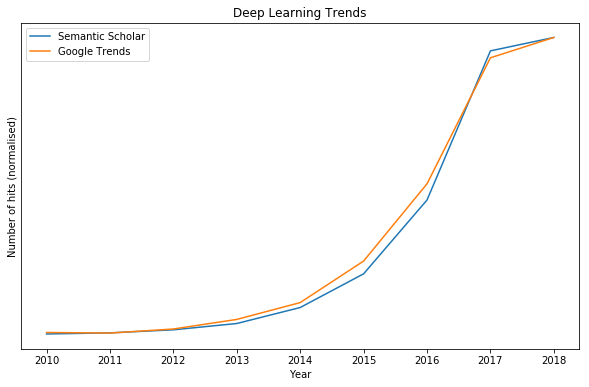

In [39]:
p = trends.plot(title = 'Deep Learning Trends', figsize=(10,6))
p.set_ylabel('Number of hits (normalised)')
p.tick_params(axis='y', which='both', left=False, labelleft=False)
plt.savefig('../writing/figures/trends.pdf', bbox_inches='tight')

In [40]:
adult = pd.read_csv('../data/adult.csv')

In [45]:
adult_sample = adult.loc[:5,['age','occupation', 'education', 'race', 'sex', '>=50k']]

In [46]:
adult_sample.to_csv('../data/adult_sample.csv', index=None)

# Chapter 2

In [735]:
def f1(x):
    return x**2

def f2(x):
    return x**2+100#-x**2 + 40*x

In [736]:
x11 = np.arange(-18,18,0.5)
x12 = f1(x11)

x21 = np.arange(-18,18,0.5)
x22 = f2(x21)

In [737]:
x1 = np.concatenate([x11, x21])
x2 = np.concatenate([x12, x22])

In [738]:
X = np.hstack([x1[:,None], x2[:,None]]).astype(np.float32)
y = np.concatenate([np.zeros_like(x11), np.ones_like(x12)]).astype(np.int64)

In [739]:
X = (X-np.mean(X,0))/np.std(X,0)

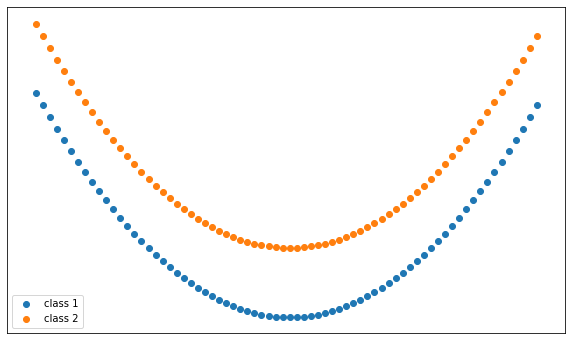

In [740]:
fig, ax = plt.subplots(figsize=(10,6))
ax.scatter(X[y==0, 0], X[y==0,1], label='class 1')
ax.scatter(X[y==1, 0], X[y==1,1], label='class 2')
ax.axes.get_xaxis().set_visible(False)
ax.axes.get_yaxis().set_visible(False)
ax.legend()
plt.savefig('../writing/figures/simple_dataset.pdf', bbox_inches='tight')

In [741]:
from fastai import *

In [742]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(2, 2)
    
    def forward(self, x):
        x = self.fc1(x)
        return x

In [762]:
model = SimpleCNN()

In [763]:
ds = TensorDataset(torch.from_numpy(X), torch.from_numpy(y))
dl = DataLoader(dataset=ds, batch_size=8, shuffle=True)

In [764]:
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

In [765]:
tmp = []
for epoch in range(100):
    train_epoch(model, dl, optimizer, F.cross_entropy)
    tmp += [validate(model, dl, F.cross_entropy)]

In [767]:
X_mins = np.min(X, 0)*1.05
X_maxs = np.max(X, 0)*1.05

In [768]:
x1_all = np.arange(X_mins[0], X_maxs[0], (X_maxs[0]-X_mins[0])/100)
x2_all = np.arange(X_mins[1], X_maxs[1], (X_maxs[1]-X_mins[1])/100)

In [769]:
X_all = np.vstack(list(itertools.product(x1_all,x2_all))).astype(np.float32)

In [770]:
ds_all = TensorDataset(torch.from_numpy(X_all))
dl_all = DataLoader(dataset=ds_all, batch_size=32)

In [966]:
def get_shade_preds(model:nn.Module, dl:DataLoader, sft=True)->None:
    model.eval()
    preds=[]
    for xb in dl:
        preds.append(model(xb[0]))
    preds = torch.cat(preds)
    if sft: preds = F.softmax(preds, 1)[:,1]
    return np.array(preds)[:,1]

In [772]:
preds = get_shade_preds(model, dl_all)

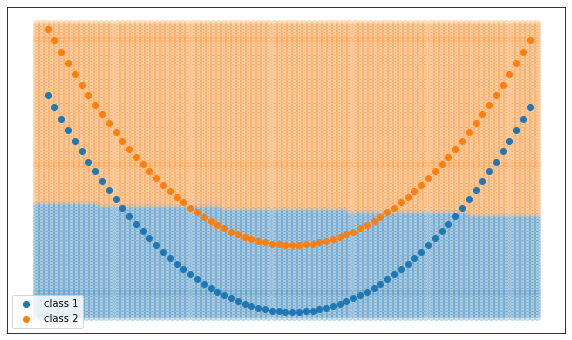

In [773]:
fig, ax = plt.subplots(figsize=(10,6))
ax.scatter(X_all[preds<0.5,0],X_all[preds<0.5,1], alpha=0.2, color=plt.cm.tab10(0))
ax.scatter(X_all[preds>0.5,0],X_all[preds>0.5,1], alpha=0.2, color=plt.cm.tab10(1))
ax.scatter(X[y==0,0], X[y==0,1], label='class 1', color=plt.cm.tab10(0))
ax.scatter(X[y==1,0], X[y==1,1], label='class 2', color=plt.cm.tab10(1))
ax.axes.get_xaxis().set_visible(False)
ax.axes.get_yaxis().set_visible(False)
ax.legend()
plt.savefig('../writing/figures/simple_dataset_simpleNN.pdf', bbox_inches='tight')

In [774]:
class ComplexCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(2, 2)
        self.a1 = nn.Sigmoid()
        self.fc2 = nn.Linear(2, 2)
#         self.a1 = nn.ReLU(inplace=True)
#         self.a1 = nn.Tanh()
    
    def forward(self, x):
        x = self.a1(self.fc1(x))
        x = self.fc2(x)
#         x = F.softmax(x, 1)
        return x

In [775]:
model = ComplexCNN()

In [776]:
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)

In [777]:
tmp = []
for epoch in range(500):
    train_epoch(model, dl, optimizer, F.cross_entropy)
    tmp += [validate(model, dl, F.cross_entropy)]

In [779]:
preds = get_shade_preds(model, dl_all)

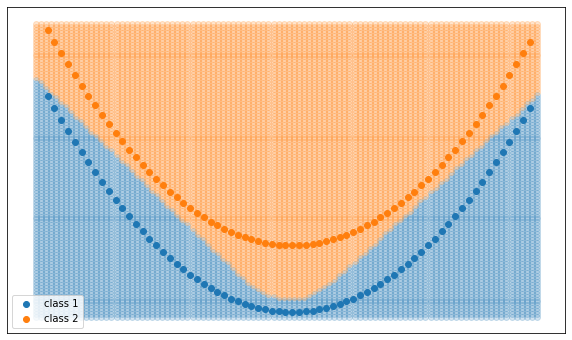

In [781]:
fig, ax = plt.subplots(figsize=(10,6))
ax.scatter(X_all[preds<0.5,0],X_all[preds<0.5,1], alpha=0.2, color=plt.cm.tab10(0))
ax.scatter(X_all[preds>0.5,0],X_all[preds>0.5,1], alpha=0.2, color=plt.cm.tab10(1))
ax.scatter(X[y==0,0], X[y==0,1], label='class 1', color=plt.cm.tab10(0))
ax.scatter(X[y==1,0], X[y==1,1], label='class 2', color=plt.cm.tab10(1))
ax.axes.get_xaxis().set_visible(False)
ax.axes.get_yaxis().set_visible(False)
ax.legend()
plt.savefig('../writing/figures/simple_dataset_complexNN.pdf', bbox_inches='tight')

In [782]:
extractor=nn.Sequential(*[model.fc1, model.a1])

In [785]:
extractor.eval()
rep=[]
y_new=[]
for xb,yb in dl:
    rep += [extractor(xb)]
    y_new += [yb]
rep = np.array(torch.cat(rep))
y_new = np.array(torch.cat(y_new))

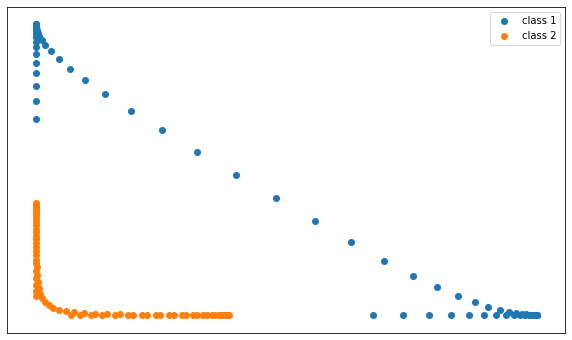

In [789]:
fig, ax = plt.subplots(figsize=(10,6))
# ax.scatter(X_all[preds<0.5,0],X_all[preds<0.5,1], alpha=0.2, color=plt.cm.tab10(0))
# ax.scatter(X_all[preds>0.5,0],X_all[preds>0.5,1], alpha=0.2, color=plt.cm.tab10(1))
ax.scatter(rep[y_new==0,0], rep[y_new==0,1], label='class 1', color=plt.cm.tab10(0))
ax.scatter(rep[y_new==1,0], rep[y_new==1,1], label='class 2', color=plt.cm.tab10(1))
ax.axes.get_xaxis().set_visible(False)
ax.axes.get_yaxis().set_visible(False)
ax.legend()
plt.savefig('../writing/figures/simple_dataset_complexNN_rep.pdf', bbox_inches='tight')

# Chapter 4

In [1022]:
def f1(x):
    return x**2

def f2(x):
    return -x**2 + 40*x #x**2+100

In [1203]:
from sklearn.datasets import make_moons, make_circles

In [1322]:
X, y = make_circles(20, noise=0.1, factor=0.2)

In [1384]:
X, y = make_moons(100, noise=0.05)

In [1385]:
X = X.astype(np.float32)
y = y.astype(np.float32)

In [1386]:
X = (X-np.mean(X,0))/np.std(X,0)

In [1387]:
def mixup_sample():
    pair_ind = np.random.choice(len(X), 2, replace=False)
    lambd = np.random.beta(0.1,0.1)
    X_m = (1-lambd)*X[pair_ind[0],:] + lambd*X[pair_ind[1],:]
    y_m = (1-lambd)*y[pair_ind[0]] + lambd*y[pair_ind[1]]
    return X_m, y_m

In [1388]:
X_mu=[]
y_mu=[]
for i in range(len(X)*8):
    xm, ym = mixup_sample()
    X_mu.append(xm)
    y_mu.append(ym)

X_mu = np.vstack(X_mu)
y_mu = np.array(y_mu)

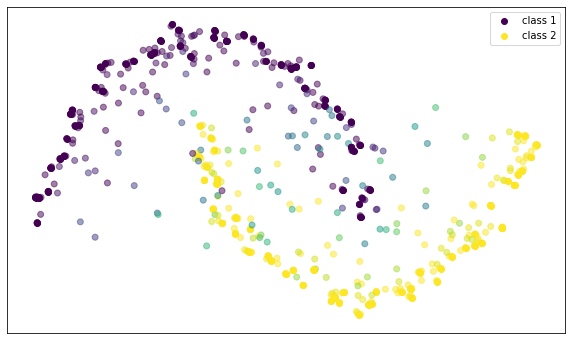

In [1389]:
fig, ax = plt.subplots(figsize=(10,6))
ax.scatter(X[y==0, 0], X[y==0,1], label='class 1', color=plt.cm.viridis(0.0001))
ax.scatter(X[y==1, 0], X[y==1,1], label='class 2', color=plt.cm.viridis(0.9999))
ax.scatter(X_mu[:,0], X_mu[:,1], color = plt.cm.viridis(np.clip(y_mu, 0.0001,0.9999)), alpha=0.5)
ax.axes.get_xaxis().set_visible(False)
ax.axes.get_yaxis().set_visible(False)
ax.legend()
plt.savefig('../writing/figures/simple_dataset_mixup.pdf', bbox_inches='tight')

In [1390]:
y_tmp = np.concatenate([y, y_mu]).astype(np.float32)
y_tmp=y_tmp[:,None]
y_tmp = np.hstack([1-y_tmp, y_tmp])

In [1391]:
ds_m = TensorDataset(torch.from_numpy(np.vstack([X, X_mu])), torch.from_numpy(y_tmp))
dl_m = DataLoader(dataset=ds_m, batch_size=32)

In [1392]:
y_tmp = y.astype(np.float32)
y_tmp=y_tmp[:,None]
y_tmp = np.hstack([1-y_tmp, y_tmp])

ds = TensorDataset(torch.from_numpy(X), torch.from_numpy(y_tmp))
dl = DataLoader(dataset=ds, batch_size=32)

In [1393]:
class ComplexCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(2, 100)
#         self.a1 = nn.Sigmoid()
        self.fc2 = nn.Linear(100, 2)
#         self.a1 = nn.ReLU(inplace=True)
        self.a1 = nn.Tanh()
    
    def forward(self, x):
        x = self.a1(self.fc1(x))
        x = self.fc2(x)
        x = F.softmax(x, 1)
        return x

In [1433]:
model = ComplexCNN()

In [1434]:
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)

In [1440]:
tmp = []
for epoch in range(100):
    train_epoch(model, dl_m, optimizer, F.binary_cross_entropy)
    tmp += [validate(model, dl_m, F.binary_cross_entropy)]

In [1441]:
tmp

[0.12679866,
 0.12678854,
 0.12677848,
 0.1267684,
 0.12675834,
 0.12674825,
 0.12673822,
 0.12672815,
 0.12671812,
 0.12670808,
 0.12669806,
 0.12668803,
 0.12667803,
 0.12666802,
 0.12665801,
 0.12664802,
 0.12663801,
 0.12662803,
 0.12661803,
 0.12660807,
 0.12659809,
 0.12658809,
 0.12657812,
 0.12656818,
 0.1265582,
 0.12654823,
 0.12653826,
 0.1265283,
 0.12651834,
 0.12650838,
 0.12649842,
 0.12648845,
 0.12647851,
 0.12646855,
 0.1264586,
 0.12644863,
 0.12643866,
 0.12642872,
 0.12641875,
 0.1264088,
 0.12639883,
 0.12638888,
 0.12637892,
 0.12636895,
 0.12635899,
 0.12634903,
 0.12633906,
 0.1263291,
 0.12631911,
 0.12630916,
 0.12629917,
 0.1262892,
 0.1262792,
 0.12626924,
 0.12625925,
 0.12624927,
 0.12623927,
 0.12622927,
 0.1262193,
 0.12620929,
 0.12619928,
 0.12618928,
 0.12617928,
 0.12616926,
 0.12615925,
 0.12614924,
 0.12613922,
 0.12612921,
 0.12611917,
 0.12610912,
 0.12609911,
 0.1260891,
 0.12607905,
 0.12606901,
 0.12605895,
 0.1260489,
 0.12603885,
 0.1260287

In [1442]:
preds = get_shade_preds(model, dl_all, sft=False)

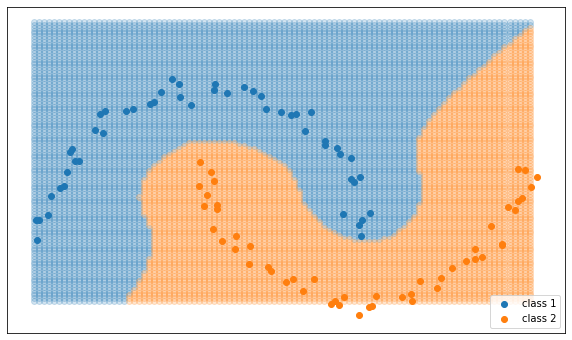

In [1443]:
fig, ax = plt.subplots(figsize=(10,6))
ax.scatter(X_all[preds<0.5,0],X_all[preds<0.5,1], alpha=0.2, color=plt.cm.tab10(0))
ax.scatter(X_all[preds>0.5,0],X_all[preds>0.5,1], alpha=0.2, color=plt.cm.tab10(1))
ax.scatter(X[y==0,0], X[y==0,1], label='class 1', color=plt.cm.tab10(0))
ax.scatter(X[y==1,0], X[y==1,1], label='class 2', color=plt.cm.tab10(1))
ax.axes.get_xaxis().set_visible(False)
ax.axes.get_yaxis().set_visible(False)
ax.legend()
# plt.savefig('../writing/figures/simple_dataset_complexNN.pdf', bbox_inches='tight')

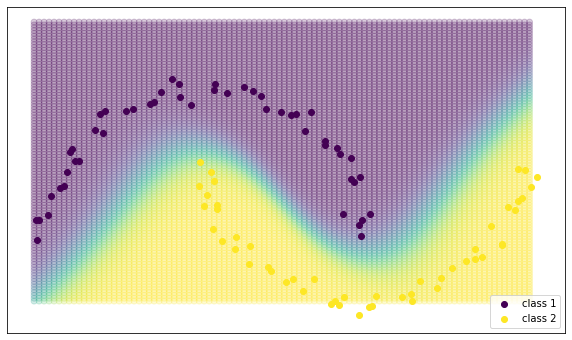

In [1432]:
fig, ax = plt.subplots(figsize=(10,6))
ax.scatter(X_all[:,0],X_all[:,1], alpha=0.2, color=plt.cm.viridis(np.clip(preds, 0.001, 0.999)))
ax.scatter(X[y==0,0], X[y==0,1], label='class 1', color=plt.cm.viridis(0.001))
ax.scatter(X[y==1,0], X[y==1,1], label='class 2', color=plt.cm.viridis(0.999))
ax.axes.get_xaxis().set_visible(False)
ax.axes.get_yaxis().set_visible(False)
ax.legend()
# plt.savefig('../writing/figures/simple_dataset_complexNN.pdf', bbox_inches='tight')

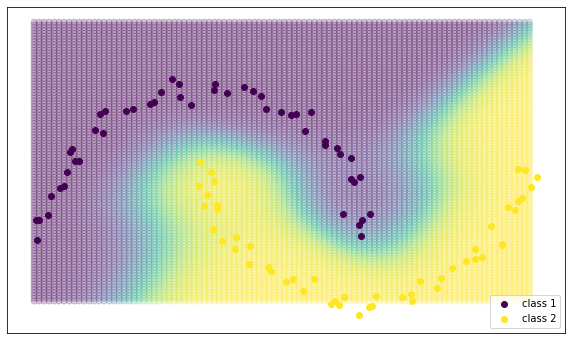

In [1444]:
fig, ax = plt.subplots(figsize=(10,6))
ax.scatter(X_all[:,0],X_all[:,1], alpha=0.2, color=plt.cm.viridis(np.clip(preds, 0.001, 0.999)))
ax.scatter(X[y==0,0], X[y==0,1], label='class 1', color=plt.cm.viridis(0.001))
ax.scatter(X[y==1,0], X[y==1,1], label='class 2', color=plt.cm.viridis(0.999))
ax.axes.get_xaxis().set_visible(False)
ax.axes.get_yaxis().set_visible(False)
ax.legend()
# plt.savefig('../writing/figures/simple_dataset_complexNN.pdf', bbox_inches='tight')

# Chapeter 6

## Cross-validation

In [4]:
from sklearn.model_selection import KFold

In [5]:
kf = KFold(5)

In [19]:
np.array(range(20)).shape

(20,)

In [20]:
next(iter(kf.split(np.array(range(20)))))

(array([ 4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]),
 array([0, 1, 2, 3]))

In [63]:
def plot_cv_indices(cv, X, ax, n_splits, lw=10):
    for ii, (tr, tt) in enumerate(cv.split(X=X)):
        indices = np.array([np.nan] * len(X))
        indices[tt] = 1
        indices[tr] = 0

        ax.scatter(range(len(indices)), [ii + .5] * len(indices),
                   c=indices, marker='_', lw=lw, cmap=plt.cm.coolwarm,
                   vmin=-.2, vmax=1.2)

    yticklabels = np.arange(1,n_splits+1)
    ax.set(yticks=np.arange(n_splits+2) + .5, yticklabels=yticklabels,
           xlabel='Sample index', ylabel="CV iteration",
           ylim=[n_splits+.2, -.2], xlim=[0, 100])
    ax.set_title('5-fold Cross-Validation', fontsize=15)
    return ax

In [69]:
import matplotlib.patches as mpatches

In [74]:
hand = [mpatches.Patch(color=plt.cm.coolwarm(i+.2), label=sub) for i,sub in enumerate(['train', 'test'])]

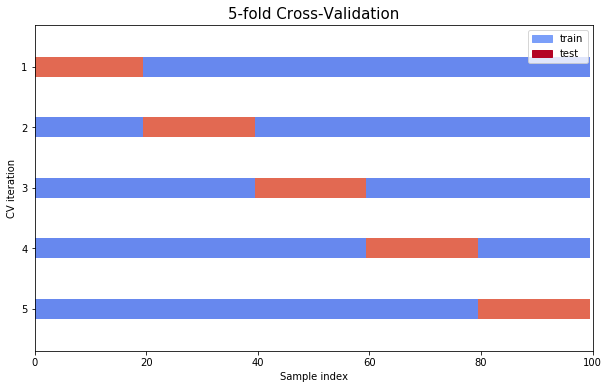

In [76]:
fig, ax = plt.subplots(figsize=(10,6))
plot_cv_indices(kf, np.array(range(100)), ax, 5, lw=20)
ax.legend(handles=hand)
plt.savefig('../writing/figures/cv.pdf', bbox_inches='tight')